[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/diogoflim/PO_II/blob/main/3_Otimização_Redes/Fluxo_CustoMin/fluxocustomin.ipynb)

## **Pesquisa Operacional II**

**Prof. Diogo Ferreira de Lima Silva (TEP-UFF)**

# Fluxo de Custo Mínimo

In [ ]:
#Execute esse bloco caso esteja executando no Google Colab
!pip install -q pyomo
!apt-get install -y -qq glpk-utils

In [12]:
import pyomo.environ as pe
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

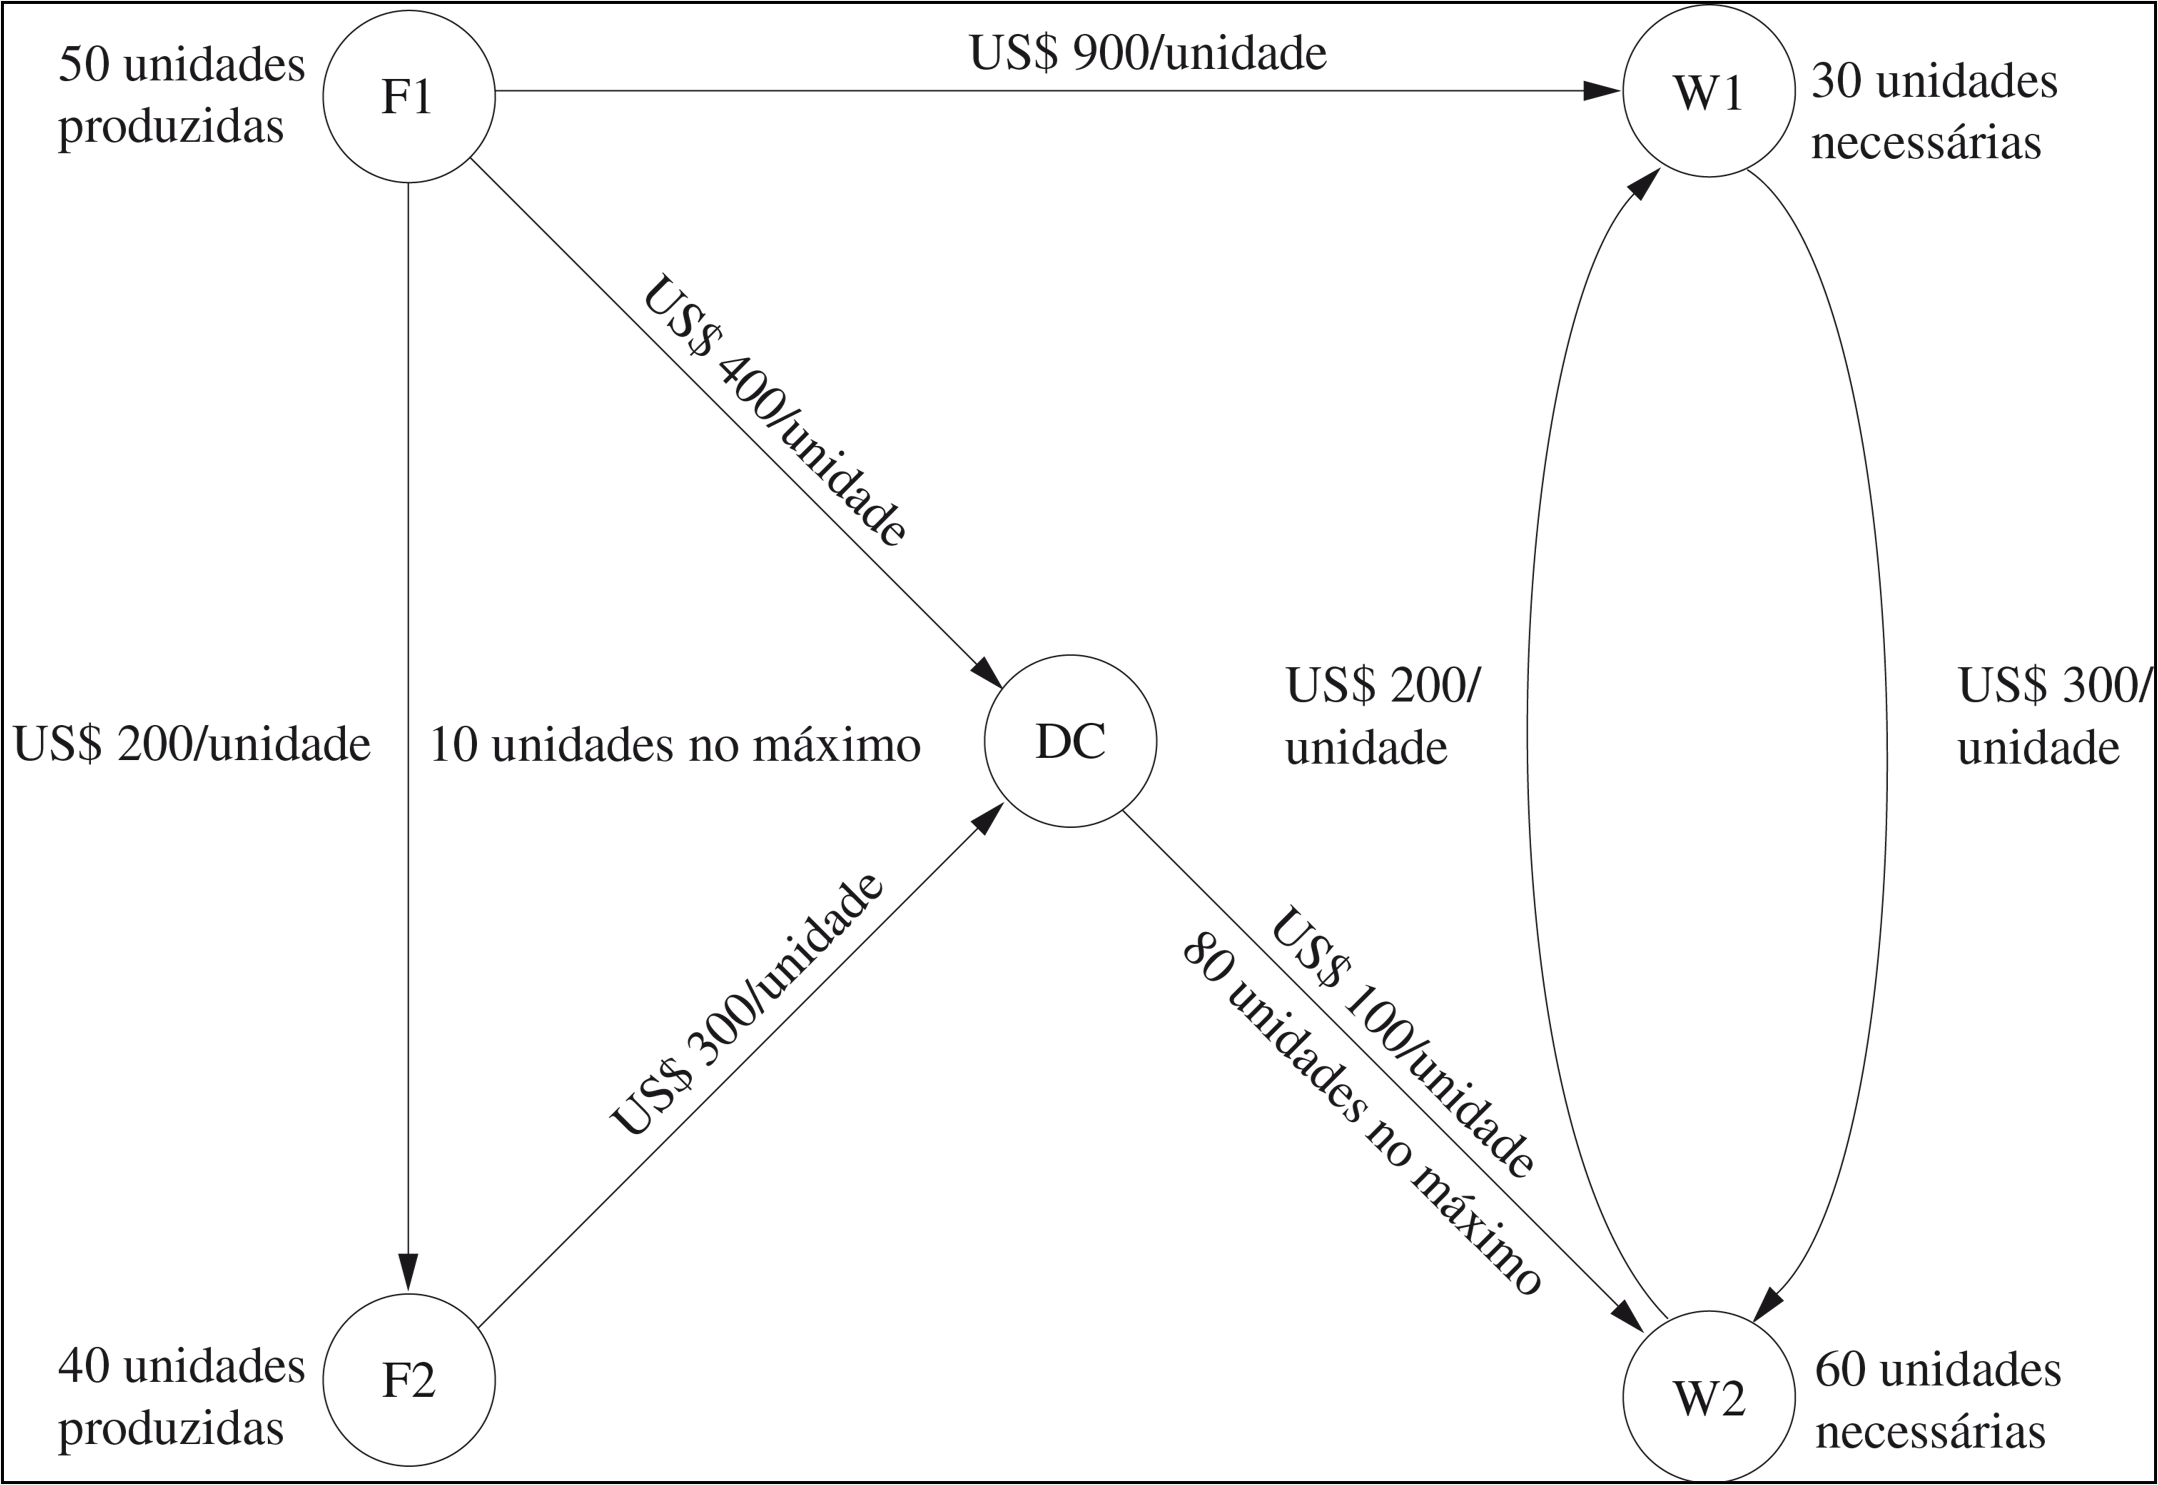

In [13]:
from IPython import display
display.Image("fluxo.png", width = 500)

## Primeiramente, vamos criar o grafo

Para isso, definiremos um conjunto de vértices e um conjunto de arestas

In [45]:
V = ['F1', 'F2', 'DC', 'W1', 'W2']
E = [('F1', 'F2'), ('F1', 'DC'), ('F1', 'W1'), ('F2', 'DC'), ('DC', 'W2'), ('W1', 'W2'), ('W2', 'W1')]

Agora, vamos passar os parâmetros do problema através de dicionários. Temos:
- Custos nas arestas
- Alguns limites superiores
- Fluxos dos vértices!

In [46]:
c = {('F1', 'F2'): 200,
     ('F1', 'DC'): 400,
     ('F1', 'W1'): 900,
     ('F2', 'DC'): 300,
     ('DC', 'W2'): 100,
     ('W1', 'W2'): 300,
     ('W2', 'W1'): 200}

u = {('F1', 'F2'): 10, ('DC', 'W2'): 80}

b = {'F1': 50, 'F2': 40, 'DC': 0, 'W1': -30, 'W2': -60}

Agora, vamos modelar no Pyomo! Iniciamos instanciando o nosso modelo.

In [47]:
M = pe.ConcreteModel()

Em seguida, vamos criar nossos conjuntos a partir de V e E!

In [48]:
M.V = pe.Set(initialize= V)
M.E = pe.Set(initialize= E)

Temos uma variável de decisão para cada aresta! Veja abaixo!

In [49]:
M.x = pe.Var(M.E, within = pe.NonNegativeReals)

Vamos passar também nossos parâmetros para o modelo!

In [50]:
M.c = pe.Param(M.E, initialize= c)
M.u = pe.Param(M.E, initialize= u)
M.b = pe.Param(M.V, initialize = b)

In [51]:
# Função Objetivo:

M.z = pe.Objective(rule = sum(M.x[e] * M.c[e] for e in M.E))

In [52]:
# Restrições:

M.fluxos = pe.ConstraintList()

for v in M.V:
    M.fluxos.add(expr = sum(M.x[e] for e in M.E if e[0] == v) - sum(M.x[e] for e in M.E if e[1] == v) == M.b[v])


M.limitesuperior =pe.ConstraintList()

for e in list(u.keys()):
    M.limitesuperior.add(expr =  M.x[e] <= M.u[e])

In [53]:
# RESOLUÇÃO DO MODELO
pe.SolverFactory('glpk').solve(M)

{'Problem': [{'Name': 'unknown', 'Lower bound': 49000.0, 'Upper bound': 49000.0, 'Number of objectives': 1, 'Number of constraints': 8, 'Number of variables': 8, 'Number of nonzeros': 17, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.04462695121765137}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [54]:
print(f"z= {pe.value(M.z)}\n----------------\n")

for k in M.x.keys(): 
    if pe.value(M.x[k]) > 0: 
        print (f"x_{k} = {pe.value(M.x[k])}")

z= 49000.0
----------------

x_('F1', 'DC') = 40.0
x_('F1', 'W1') = 10.0
x_('F2', 'DC') = 40.0
x_('DC', 'W2') = 80.0
x_('W2', 'W1') = 20.0


## Modelando um Problema de Transportes como Fluxo de Custo Mínimo

Uma empresa possui três fábricas que produzem carrinhos de bebê que devem ser remetidos para quatro centros de distribuição. As Fábricas F1, F2 e F3 produzem, respectivamente, 12, 17 e 11 remessas por mês. Cada centro de distribuição CD precisa receber dez remessas por mês. Com base na tabela de custos abaixo, que mostra o custo unitário de transporte das Fábricas à cada CD, quanto deve ser remetido de cada fábrica para cada um dos centros de distribuição para minimizar o custo total de transporte?

<center>

|Fábrica|$CD1$|$CD2$|$CD3$|$CD4$|
|:-----:|:---:|:---:|:---:|:---:|
|$F1$   |40100|65100|20100|35100|
|$F2$   |55100|70100|30100|50100|
|$F3$   |30100|60100|40100|45100|

</center>


In [ ]:
custos = pd.DataFrame ({"CD1": [40100, 55100, 30100],
                        "CD2": [65100, 70100, 60100],
                        "CD3": [20100, 30100, 40100],
                        "CD4": [35100, 50100, 45100]
                        }, index = ["F1", "F2", "F3"]) 

custos

In [ ]:
c_dict = custos.stack().to_dict()
c_dict

In [ ]:
fluxos = {'F1':12,'F2':17, 'F3': 11, 'CD1':-10,'CD2':-10,'CD3':-10,'CD4':-10}
fluxos

In [ ]:
# Criando uma instância do modelo
M = pe.ConcreteModel() 

In [ ]:
M.V = pe.Set(initialize = list(custos.index) + list(custos.columns)) # Conjunto de vértices
M.E = pe.Set(initialize = c_dict.keys())

In [ ]:
M.pprint()

In [ ]:
# PASSANDO OS PARÂMETROS DO PROBLEMA

# Custos de transporte da fábrica i para o centro de dsitribuição j
M.c = pe.Param(M.E, initialize = c_dict)
M.b = pe.Param(M.V, initialize = fluxos)
 

In [ ]:
# VARIÁVEIS DE DECISÃO
# xij representa a quantidade de remessas enviada da fábrica i para o CD j
M.x = pe.Var(M.E, within= pe.NonNegativeReals)


In [ ]:
def custo_total (M):
    return sum(M.x[e] * M.c[e] for e in M.E)

# FUNÇÃO OBJETIVO
M.z = pe.Objective(rule = custo_total, sense= pe.minimize)
  

In [ ]:
M.R_fluxos = pe.Constraint(M.V, 
                           rule= lambda M, i: sum(M.x[(i, j)] for j in M.V if (i,j) in M.E) - sum(M.x[(j, i)] for j in M.V if (j,i) in M.E) == M.b[i])


In [ ]:
# RESOLUÇÃO DO MODELO
pe.SolverFactory('glpk').solve(M)

In [ ]:
print(f"z= {pe.value(M.z)}\n----------------\n")

for k in M.x.keys(): 
    if pe.value(M.x[k]) > 0: 
        print (f"x_{k} = {pe.value(M.x[k])}")

## Modelando um Problema do Fluxo Máximo como Problema do Fluxo de Custo Mínimo

In [ ]:
# Cria um objeto de grafo direcionado
G = nx.DiGraph()

# Adiciona nós ao grafo
G.add_node('s')  # Nó fonte
G.add_node('a')
G.add_node('b')
G.add_node('c')
G.add_node('d')
G.add_node('t')  # Nó destino

# Adiciona arestas ao grafo com suas capacidades
G.add_edge('s', 'a', capacidade=3)
G.add_edge('s', 'b', capacidade=2)
G.add_edge('a', 'b', capacidade=1)
G.add_edge('a', 'c', capacidade=3)
G.add_edge('b', 'd', capacidade=2)
G.add_edge('c', 'd', capacidade=2)
G.add_edge('c', 't', capacidade=3)
G.add_edge('d', 't', capacidade=3)


In [ ]:
# Desenha o grafo com os rótulos de capacidade nas arestas

pos =  nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_size = 800)
aresta_rotulos = {(u, v): d['capacidade'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=aresta_rotulos, font_color='red')
plt.show()


In [ ]:
V = list(G.nodes())
E = list(G.edges())

E.append(('s','t'))


print(V)
print(E)

In [ ]:
u = nx.get_edge_attributes(G, 'capacidade')
u[('s','t')] = 10000
u


In [ ]:
c = {}
for e in E: c[e] = 0
c[('s','t')] = 100
c

In [ ]:
F = 8

fluxos = {'s': F,
          'a':0,
          'b':0,
          'c':0,
          'd':0,
           't': -F}

fluxos

In [ ]:
# Criando uma instância do modelo
M2 = pe.ConcreteModel() 

# Grafo
M2.V = pe.Set(initialize = V) 
M2.E = pe.Set(initialize = E)

#Parâmetros
M2.c = pe.Param(M2.E, initialize = c) #custos
M2.u = pe.Param(M2.E, initialize = u) #limites superiores
M2.b = pe.Param(M2.V, initialize = fluxos) #fluxos


In [ ]:
# VARIÁVEIS DE DECISÃO
M2.x = pe.Var(M2.E, within= pe.NonNegativeReals)


In [ ]:
def custo_total (M2):
    return sum(M2.x[e] * M2.c[e] for e in M2.E)

# FUNÇÃO OBJETIVO
M2.z = pe.Objective(rule = custo_total, sense= pe.minimize)
  

In [ ]:
M2.R_fluxos = pe.Constraint(M2.V, rule= lambda M2, i: sum(M2.x[(i, j)] for j in M2.V if (i,j) in M2.E) - sum(M2.x[(j, i)] for j in M2.V if (j,i) in M2.E) == M2.b[i])


M2.R_limites =pe.ConstraintList()
for e in M2.E:
    M2.R_limites.add(expr =  M2.x[e] <= M2.u[e])


In [ ]:
# RESOLUÇÃO DO MODELO
pe.SolverFactory('glpk').solve(M2)

In [ ]:
print(f"z= {pe.value(M2.z)}\n----------------\n")
for k in M2.x.keys(): 
    if pe.value(M2.x[k]) > 0: 
        print (f"x_{k} = {pe.value(M2.x[k])}")

Perceba que foram enviadas 3 unidades via arco fantasma ('s', 't'). Por isso o custo foi de 300! 

Para encontrar a resposta do fluxo máximo, basta somar o que saiu do vértice 's' ou somar o que entrou em 't',  **sem contar o arco ('s', 't')**.

In [ ]:
resposta_1 = sum(pe.value(M2.x[k]) for k in M2.x.keys() if k[0] == 's' and k[1]!='t')
# ou
resposta_2 = sum(pe.value(M2.x[k]) for k in M2.x.keys() if k[0] != 's' and k[1]=='t')
# ou
resposta_3 = sum(pe.value(M2.x[k]) for k in M2.x.keys() if k!= ('s','t') and k[0] == 's')
# ou
resposta_4 = sum(pe.value(M2.x[k]) for k in M2.x.keys() if k!= ('s','t') and k[1] == 't')

print(resposta_1)
print(resposta_2)
print(resposta_3)
print(resposta_4)